In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pylatexenc
import math
from sklearn.preprocessing import MinMaxScaler
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.model_selection import train_test_split
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler,Estimator, Options

In [2]:
df = pd.read_csv ('dataset.csv')
df.head()
df = df.drop(['x_std','z_std','y_mean','y_std','theta_std_dc','v_wind', 'theta_wind','dcd','rcp', 'T_wind'], axis=1)
df.head(1)

,theta_avg_dc,outlet_area,flowrate,dch,dcw,T_delta_mean
0,0,1879.2,18699822,15.3,12,1


In [3]:
#Prepare the data
X = np.array(df[df.columns[0:-1]])
X = MinMaxScaler().fit_transform(X)
y = np.array(df['T_delta_mean'])
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


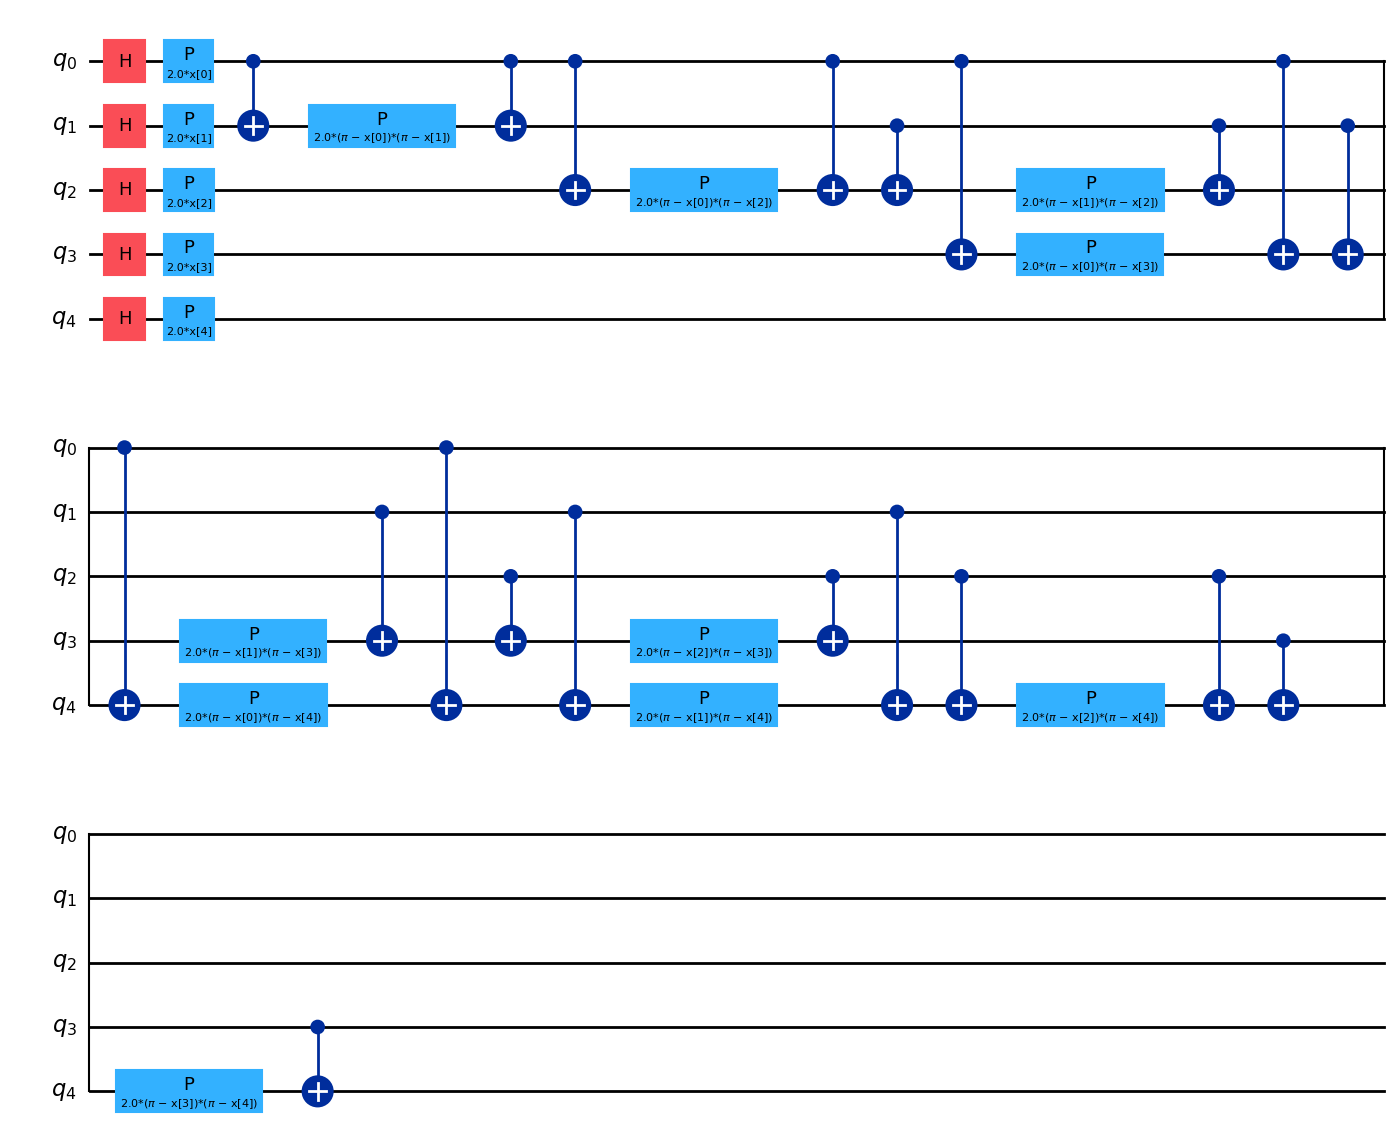

In [4]:
num_features = X.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20,style="iqp")

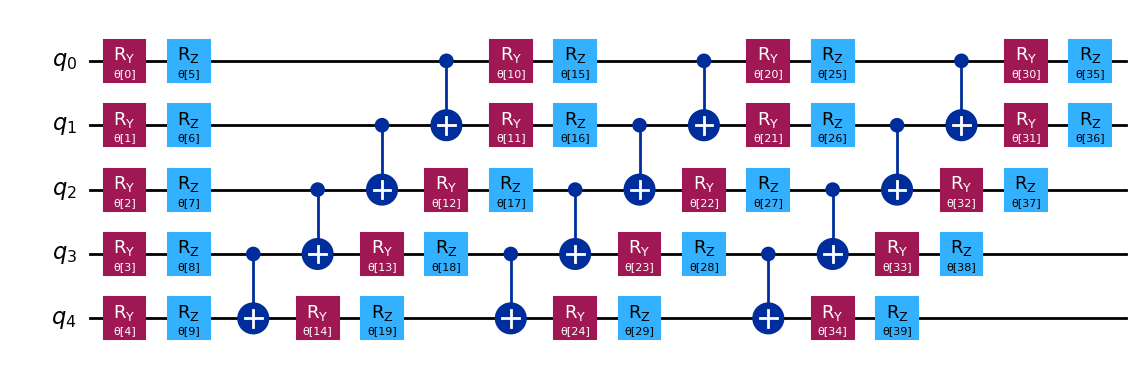

In [5]:
ansatz = EfficientSU2(num_qubits=num_features, reps=1)
ansatz.decompose().draw(output="mpl", fold=20,style="iqp")

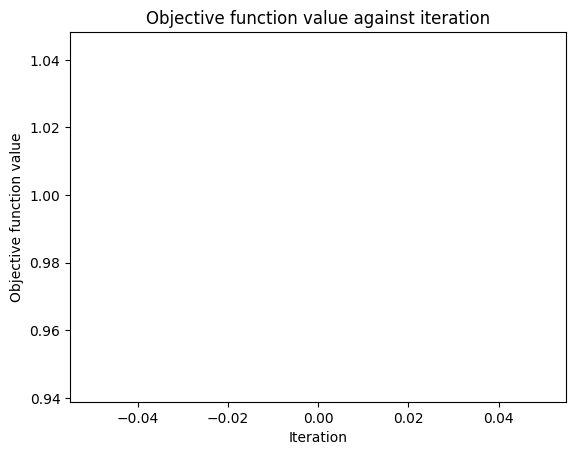

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [6]:
service = QiskitRuntimeService()
options = Options()
options.resilience_level = 1
options.optimization_level = 3
optimizer = COBYLA(maxiter=100)
with Session(service, backend=service.least_busy(simulator=False, operational=True)) as session:
    sampler = Sampler(session=session)
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
    )
    vqc.fit(X, y)
    vqc.score(X_test, y_test)